In [317]:
# General
import numpy as np
import matplotlib.pyplot as plt
import time

# Linear regression
import sklearn.linear_model

# CNN
import torch
from torch import nn, cuda
from torch.utils.data import DataLoader, Dataset

# Data preprocessing

In [318]:
# Load digits array from file
# File is formatted 200 rows per digit, each row representing a 15x16 grayscale image
digits = np.loadtxt('ProjectDigits_materials/mfeat-pix.txt', usecols=range(240))

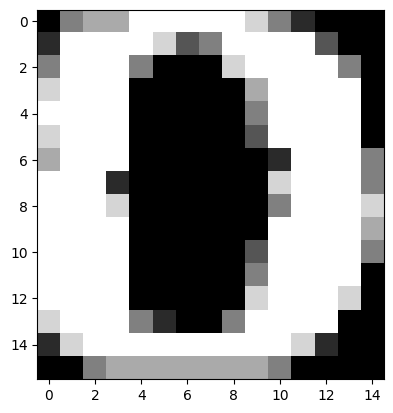

In [319]:
plt.imshow(digits[0].reshape(16,15), cmap='gray')

In [320]:
# Zero pad the data on the sides for nice and square images
# Added benefit is 2 variations of each input
vars_per_sample = 2 # Amount of variations of each digits sample
varied_digits = np.empty([digits.__len__() * vars_per_sample, 16, 16])
for i in range(digits.__len__()):
    varied_digits[vars_per_sample*i] = np.pad(digits[i].reshape(16,15), [(0,0), (1,0)], mode='constant', constant_values=0)
    varied_digits[vars_per_sample*i + 1] = np.pad(digits[i].reshape(16,15), [(0,0), (0,1)], mode='constant', constant_values=0)

In [321]:
# Split the data in train and test data, 50/50
# TODO Train data is to be split further into train and validate data, 
# so we can keep test data in a vault.
# TODO Train data is to be augmented by shifting in the 8 cardinal directions 
# so the training set is larger. Left and right are already done above

x_train = np.empty([0, 16, 16])
y_train = np.empty(0)
y_train_one_hot = np.empty([0, 10])
x_test = np.empty([0, 16, 16])
y_test = np.empty(0)
y_test_one_hot = np.empty([0, 10])

varied_digits_per_digit = np.array(np.split(varied_digits, 10))

for d in range(10):
    [d_train, d_test] = np.array(np.split(varied_digits_per_digit[d], 2))
    x_train = np.concatenate((x_train, d_train))
    x_test = np.concatenate((x_test, d_test))
    y_train = np.concatenate((y_train, np.full(d_train.__len__(), d)))
    y_test = np.concatenate((y_test, np.full(d_test.__len__(), d)))

    one_hot = np.zeros(10)
    one_hot[d] = 1
    y_train_one_hot = np.concatenate((y_train_one_hot, np.tile(one_hot, (d_train.__len__(), 1))))
    y_test_one_hot = np.concatenate((y_test_one_hot, np.tile(one_hot, (d_test.__len__(), 1))))

# Normalize the input to be in [0,1]
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

# Linear regression
A basic linear regression to sanity check results from CNN

In [322]:
# Flatten the data
x_train_flat = np.reshape(x_train, (x_train.__len__(), -1))
x_test_flat = np.reshape(x_test, (x_test.__len__(), -1))

In [323]:
# Teach basic linear regression with train data, test with test data
lr = sklearn.linear_model.LogisticRegression(solver='saga', tol=0.1)
lr = lr.fit(x_train_flat, y_train)

print(f'train: {lr.score(x_train_flat, y_train)}')
print(f'test: {lr.score(x_test_flat, y_test)}')

train: 0.9815
test: 0.957


# CNN

## Pytorch preprocessing

In [324]:
# Special torch arrays
# Taken from mnist_keras_pytorch.ipynb from tutorial
torch_x_train = torch.from_numpy(x_train)
torch_y_train = torch.from_numpy(y_train_one_hot)
torch_x_test = torch.from_numpy(x_test)
torch_y_test = torch.from_numpy(y_test_one_hot)

In [325]:
# Torch datasets
# Taken from mnist_keras_pytorch.ipynb from tutorial
class DigitsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index):
        X = self.X[index].float()
        Y = self.Y[index].long()
        return X,Y
    
train_dataset = DigitsDataset(torch_x_train, torch_y_train)
test_dataset = DigitsDataset(torch_x_test, torch_y_test)

In [326]:
# Torch dataloader
# Taken from mnist_keras_pytorch.ipynb from tutorial
if cuda.is_available():
    loader_args = dict(shuffle=True, batch_size=256, num_workers=8, pin_memory=True)
else:
    loader_args = dict(shuffle=True, batch_size=1)

train_loader = DataLoader(train_dataset, **loader_args)
test_loader = DataLoader(test_dataset, **loader_args)

## Epochs setup

In [327]:
# Taken from mnist_keras_pytorch.ipynb from tutorial
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [328]:
# Taken from mnist_keras_pytorch.ipynb from tutorial
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [329]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    Train_loss = []
    Test_loss = []
    Test_acc = []

    for i in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        test_loss, test_acc = test_model(model, test_loader, criterion)
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Test_acc.append(test_acc)
        print('='*20)

    return Train_loss, Test_loss, Test_acc

## Network attempts
https://madebyollin.github.io/convnet-calculator/ can come in very handy when determining the trainable parameters for a convolution layer.

### LeNet-5-like network
The LeNet-5 architecture was the first successfully trained CNN - it was even designed for the task we're doing, but on images of 28x28 (hence the "-like").

Its architecture is as follows:
1. Input (1@16x16)
2. Convolution -- (6@16x16)
3. Average pool -- (6@8x8)
4. Convolution -- (16@6x6)
5. Average pool -- (16@3x3)
6. Fully connected layer -- 120 nodes
7. Fully connected layer -- 84 nodes
8. Fully connected output -- one-hot encoding

In [330]:
leNet5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(0,2),
    nn.Linear(in_features=144, out_features=120), nn.Sigmoid(),
    nn.Linear(in_features=120, out_features=84), nn.Sigmoid(),
    nn.Linear(in_features=84, out_features=10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(leNet5.parameters())

print(leNet5)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=0, end_dim=2)
  (7): Linear(in_features=144, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [331]:
device = torch.device('cuda' if cuda.is_available() else 'cpu')
leNet5.to(device)

train_loss, test_loss, test_acc = train_model(leNet5, train_loader, test_loader, criterion, optimizer)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported